# **Tech Challenge 2 - Previsão Ibovespa**

# **1. Importações**

In [25]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import TimeSeriesSplit

import xgboost as xgb

## **2. Carregamento dos Dados (CSV)**

Arquivo extraído do Investing.com com dados diários do Ibovespa.

Datas extraídas:
**09.01.2008 - 27.11.2025**

In [31]:
path = "data/dados_ibovespa.csv"

df = pd.read_csv(path)
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df.set_index('Data', inplace=True)
df.sort_index(inplace=True)

df.head()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2008-01-09,62.674,62.078,62.674,61.487,"3,48M","0,96%"
2008-01-10,63.515,62.677,63.615,62.594,"3,23M","1,34%"
2008-01-11,61.942,63.514,63.514,61.942,"2,92M","-2,48%"
2008-01-14,62.188,61.950,62.536,61.643,"2,83M","0,40%"
2008-01-15,59.907,62.180,62.180,59.897,"4,08M","-3,67%"


In [32]:
df.tail()

,Último,Abertura,Máxima,Mínima,Vol.,Var%
Data,,,,,,
2025-11-21,154.770,155.381,155.387,153.571,"7,85B","-0,39%"
2025-11-24,155.278,154.769,155.832,154.529,"9,28B","0,33%"
2025-11-25,155.910,155.278,156.373,154.821,"6,93B","0,41%"
2025-11-26,158.555,155.915,158.714,155.914,"8,60B","1,70%"
2025-11-27,158.360,158.554,158.864,158.167,"4,47B","-0,12%"


# **3. Pré-Processamento dos Dados**

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4436 entries, 2008-01-09 to 2025-11-27
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Último    4436 non-null   float64
 1   Abertura  4436 non-null   float64
 2   Máxima    4436 non-null   float64
 3   Mínima    4436 non-null   float64
 4   Vol.      4435 non-null   object 
 5   Var%      4436 non-null   object 
dtypes: float64(4), object(2)
memory usage: 242.6+ KB


In [34]:
# Verificando se existem valores nulos
df.isnull().sum()

Último      0
Abertura    0
Máxima      0
Mínima      0
Vol.        1
Var%        0
dtype: int64

Foi encontrado 1 registro com Volume vazio (nulo)

In [35]:
# Removendo registro com volume vazio
df = df[~df['Vol.'].isnull()]

Tratando as Colunas Volume (Vol.) e Variação (Var%)

In [7]:
def converter_volume(vol):
    vol = str(vol).upper().strip()
    if vol.endswith('M'):
        return float(vol[:-1].replace(',', '.')) * 1_000_000
    if vol.endswith('K'):
        return float(vol[:-1].replace(',', '.')) * 1_000
    if vol.endswith('B'):
        return float(vol[:-1].replace(',', '.')) * 1_000_000_000
    return np.nan

df['Volume'] = df['Vol.'].apply(converter_volume)

for col in ['Último','Abertura','Máxima','Mínima']:
    df[col] = df[col].astype(str).str.replace('.', '').str.replace(',', '.').astype(float)

df['Var%'] = (
    df['Var%']
    .str.replace('%','')
    .str.replace(',','.')
    .astype(float) / 100
)

Tratando a coluna de Data e transformando ela em índice

In [8]:
df['Data'] = pd.to_datetime(df['Data'], dayfirst=True)
df.set_index('Data', inplace=True) # Setando a coluna Data como index
df.sort_index(inplace=True) # Ordenando por Data

## **4. Análise Exploratória (EDA)**


### Série Temporal

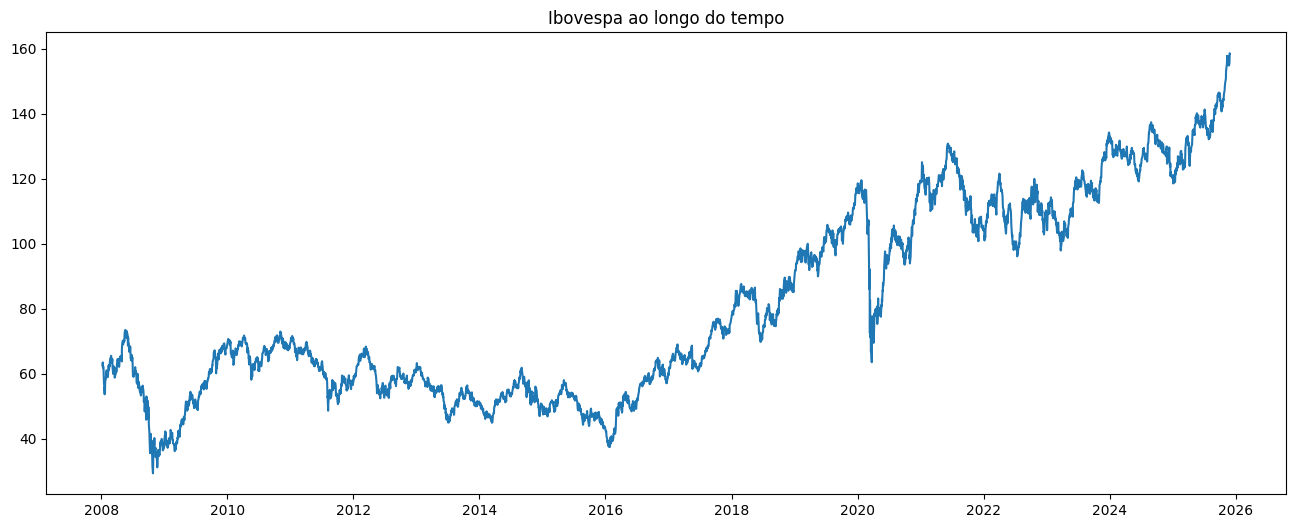

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(df['Último'])
plt.title("Fechamento do Ibovespa ao longo dos anos")
plt.show()

### Distribuições

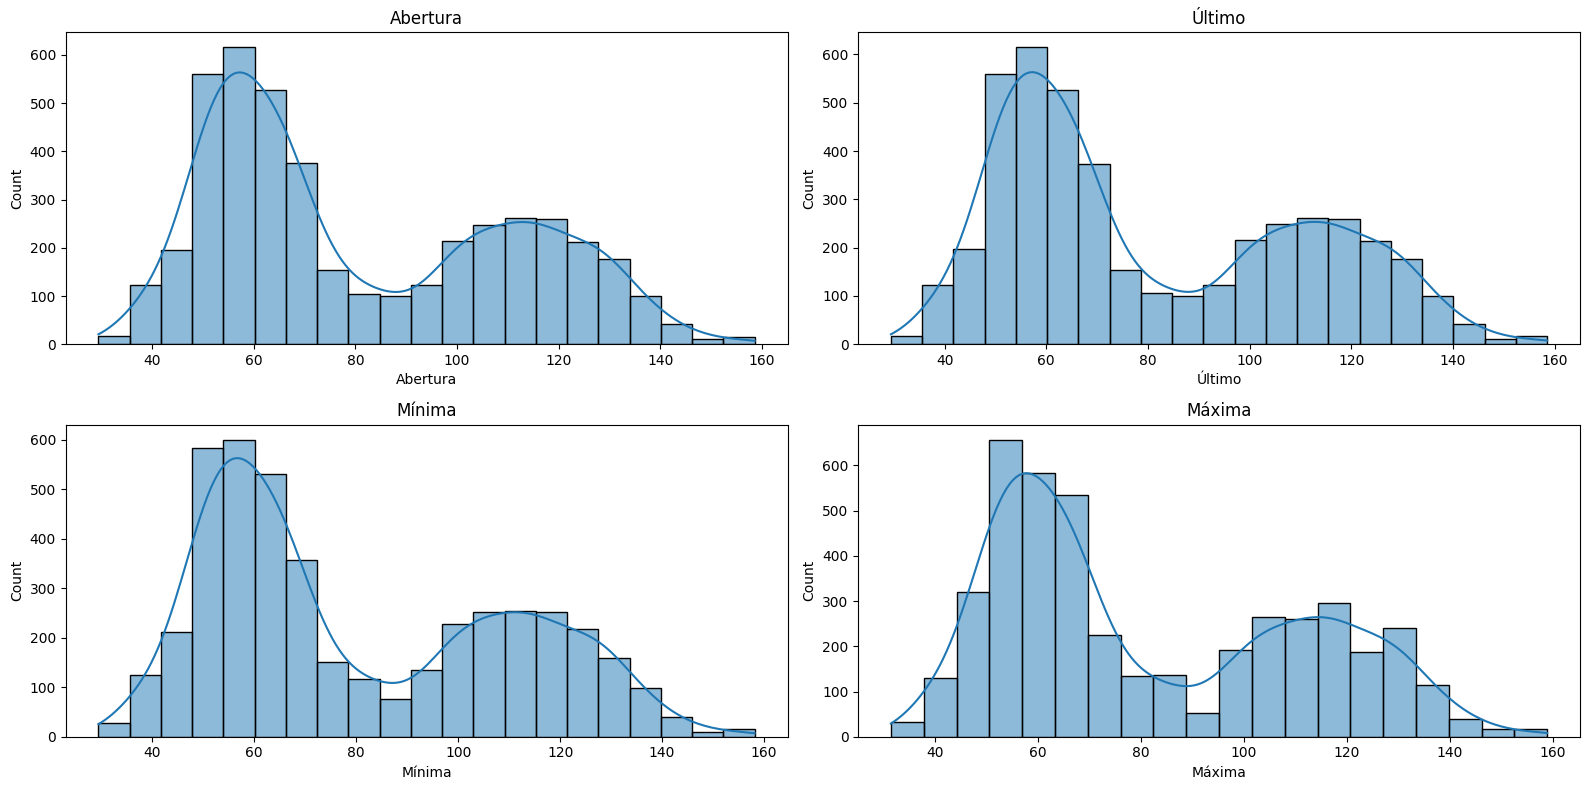

In [37]:
fig, axes = plt.subplots(2,2, figsize=(16,8))
axes = axes.flatten()

for i,col in enumerate(['Abertura','Último','Mínima','Máxima']):
    sns.histplot(df[col], kde=True, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

### **Decomposição Sazonal**

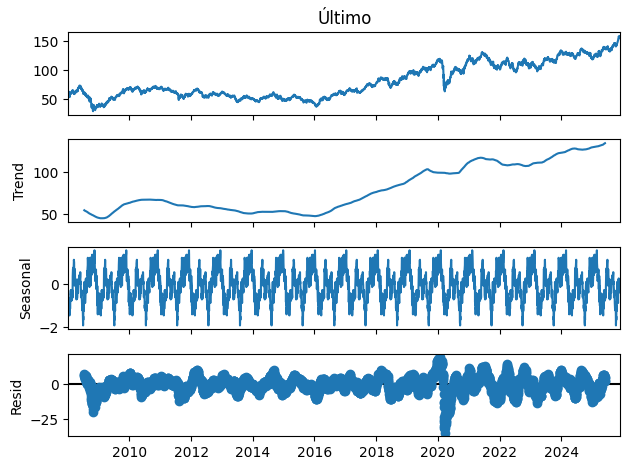

In [39]:
decomp = seasonal_decompose(df['Último'], period=252)

decomp.plot()
plt.tight_layout()
plt.show()

### Correlação entre as Variáveis 

In [42]:
plt.figure(figsize=(8,6))
sns.heatmap(
    df[['Último','Abertura','Máxima','Mínima','Vol.','Var%']].corr(),
    annot=True,
    cmap='coolwarm'
)
plt.title("Correlação entre variáveis")
plt.show()

ValueError: could not convert string to float: '3,48M'

<Figure size 800x600 with 0 Axes>

## **Realizando teste de estacionaridade (ADF)**

In [43]:
adf = adfuller(df['Último'])
print(f"ADF: {adf[0]:.4f}")
print(f"P-Value: {adf[1]:.4f}")

ADF: -0.2189
P-Value: 0.9362


Explicar

## **Aplicando Diferenciação**

In [44]:
df_diff = df.copy()
df_diff['Último'] = df_diff['Último'].diff()

df_diff.dropna(inplace=True)

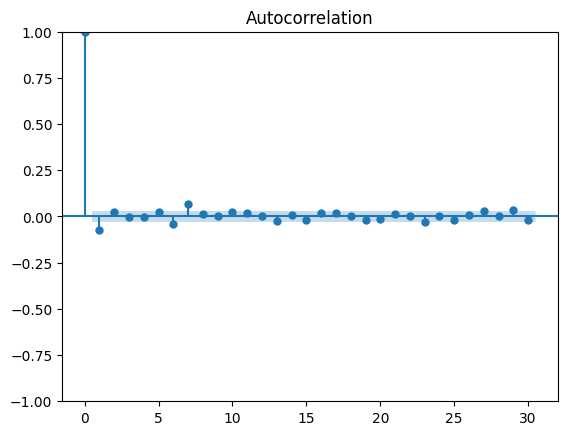

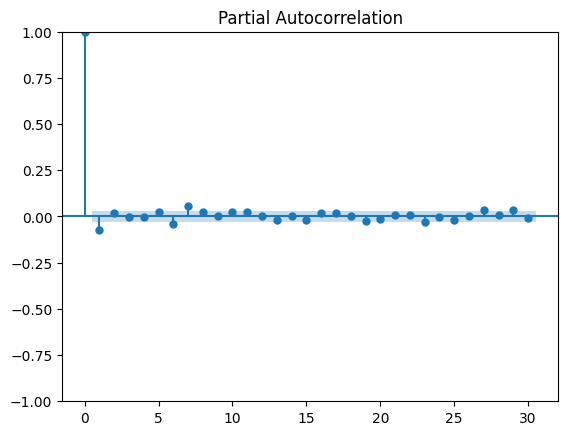

In [45]:
plot_acf(df_diff['Último'], lags=30)
plt.show()

plot_pacf(df_diff['Último'], lags=30)
plt.show()

Target

In [46]:
df_feat = pd.DataFrame()
df_feat['Fechamento'] = df_diff['Último']
df_feat['Delta'] = df_feat['Fechamento'].pct_change().shift(-1)

threshold = 0.005

df_feat['Target'] = np.where(
    df_feat['Delta'] > threshold, 1,
    np.where(df_feat['Delta'] < -threshold, 0, np.nan)
)

## **5. Feature Engeeniring**

In [47]:
df_feat['Máxima'] = df['Máxima'].shift(1)
df_feat['Mínima'] = df['Mínima'].shift(1)
df_feat['Abertura'] = df['Abertura']

df_feat['Volatilidade'] = df_feat['Máxima'] - df_feat['Mínima']
df_feat['Volatilidade_rel'] = df_feat['Volatilidade'] / df_feat['Mínima']

df_feat['MA5'] = df_feat['Fechamento'].rolling(5).mean().shift(1)
df_feat['MA22'] = df_feat['Fechamento'].rolling(22).mean().shift(1)
df_feat['MA66'] = df_feat['Fechamento'].rolling(66).mean().shift(1)

df_feat.drop(['Fechamento', 'Delta'], axis=1, inplace=True)
df_feat.dropna(inplace=True)

## **7. Definindo Base de Teste**

Split temporal = Últimos 30 dias

In [48]:
train = df_feat.iloc[:-30]
test = df_feat.iloc[-30:]

X_train = train.drop('Target', axis=1)
y_train = train['Target']

X_test = test.drop('Target', axis=1)
y_test = test['Target']

## **Modelos**

Os Modelos escolhidos para avaliação são:
- Baseline — Naive
- Seasonal Naive
- XGBoost
- AutoArima
- Prophet

### **Naive**

In [49]:
baseline_pred = y_test.shift(1).dropna()
baseline_acc = accuracy_score(y_test.loc[baseline_pred.index], baseline_pred)
print("Baseline:", baseline_acc)

Baseline: 0.3793103448275862


### **Regressão Logística**

In [51]:
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

print("LogReg Accuracy:", accuracy_score(y_test, y_pred_lr))
print(confusion_matrix(y_test, y_pred_lr))

LogReg Accuracy: 0.5666666666666667
[[17  0]
 [13  0]]


### **XGBoost**

In [52]:
neg, pos = np.bincount(y_train.astype(int))
scale_pos_weight = neg / pos

xgb_model = xgb.XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)

xgb_model.fit(X_train, y_train)

y_pred_xgb = xgb_model.predict(X_test)

print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

XGBoost Accuracy: 0.5333333333333333
[[15  2]
 [12  1]]
              precision    recall  f1-score   support

         0.0       0.56      0.88      0.68        17
         1.0       0.33      0.08      0.12        13

    accuracy                           0.53        30
   macro avg       0.44      0.48      0.40        30
weighted avg       0.46      0.53      0.44        30



### **Prophet**

In [53]:
prophet_df = df.reset_index()[['Data','Último']]
prophet_df.columns = ['ds','y']

prophet_train = prophet_df.iloc[:-30]
prophet_test = prophet_df.iloc[-30:]

model_prophet = Prophet(daily_seasonality=True)
model_prophet.fit(prophet_train)

future = model_prophet.make_future_dataframe(periods=30)
forecast = model_prophet.predict(future)

prophet_pred = (
    forecast.tail(30)['yhat'].values >
    prophet_train['y'].iloc[-30:].values
).astype(int)

acc_prophet = accuracy_score(y_test, prophet_pred)

print(f"Prophet Accuracy: {acc_prophet:.2%}")

18:57:04 - cmdstanpy - INFO - Chain [1] start processing
18:57:06 - cmdstanpy - INFO - Chain [1] done processing


Prophet Accuracy: 56.67%
